First we load the functions and libraries necessary for this report.

In [3]:
from __future__ import print_function
from lightfm import LightFM

import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
run analysis_functions.ipynb #import all helper functions

For initial analysis, we will explore and model data from only 9000 users. In future sections we will extend this model to more users. 

In [20]:
# Import main dataset
df = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
df = df.drop(['Unnamed: 0'], axis=1)

The structure of the analysis will be as such: 
0. Data Exploration
1. Objective
2. Prepare data
3. Model Fitting, Tuning, and Evaluation
    - Benchmarks
        - Most Popular
        - ALS Matrix Factorization (Implicit)
        - Bayesian Personalized Ranking (Implicit)
    - LightFM
        - FM without Side Info (Vanilla)
        - FM with User/Item Side Information
        - Parameter Tuning
    - Summary of Results between Models (Table)
4. Model Exploration
    - Metrics Used (Recall, Precision, Coverage)
    - Metrics by User Segments 
        - Active/Non-Active
        - Diverse/Non-Diverse 
        - Mainstream/Non-Mainstream 
    - Scale
        - Metrics by Size
        - Training Time / Predict Time by Size
    - Qualitative Results (Serendipity/Novelty)
6. Conclusion / Next Steps

# 0. Data Exploration

Before we dive into modeling, let's take a look at what data currently looks like. 

In [4]:
df.head()

user_id  \
0  00029d80b8af94f2d5e3349ceb28b7304f80c1c4   
1  00029d80b8af94f2d5e3349ceb28b7304f80c1c4   
2  00029d80b8af94f2d5e3349ceb28b7304f80c1c4   
3  00029d80b8af94f2d5e3349ceb28b7304f80c1c4   
4  00029d80b8af94f2d5e3349ceb28b7304f80c1c4   

                            artist_mbid              artist_name  plays  
0  b7ffd2af-418f-4be2-bdd1-22f8b48613da          nine inch nails  11092  
1  8ca01f46-53ac-4af2-8516-55a909c0905e      my bloody valentine   1671  
2  e795e03d-b5d5-4a5f-834d-162cfb308a2c                pj harvey   1603  
3  69ee3720-a7cb-4402-b48d-a02c366f2bcf                 the cure   1588  
4  90cc2464-234e-4da0-b39b-576f36e633bc  antony and the johnsons   1039

Next lets take a first, high-level look at the datset.

In [5]:
df.describe()

plays
count  438346.000000
mean      216.435998
std       800.547832
min         1.000000
25%        34.000000
50%        94.000000
75%       225.000000
max    242328.000000

In [6]:
df.describe(include = 'O')

user_id artist_mbid artist_name
count                                     438346      438346      438346
unique                                      9000       47102       53577
top     1a0cefc82b7f7566d12b69697ea91a29b20f6554               radiohead
freq                                         107        5731        1926

It's interesting to see that there are more artist names than artist mbid. This is probably because some artist names share the same mbid (seen below), due to both error and if the same artist have different names. **To distinguish between artists, we will then use artist_mbid.** FERNANDO NEED CODE HERE

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438346 entries, 0 to 438345
Data columns (total 4 columns):
user_id        438346 non-null object
artist_mbid    438346 non-null object
artist_name    438346 non-null object
plays          438346 non-null int64
dtypes: int64(1), object(3)
memory usage: 13.4+ MB


Let's see if there's any missing values within the dataset.

In [8]:
df.isna().sum()

user_id        0
artist_mbid    0
artist_name    0
plays          0
dtype: int64

Let's see if there's any wrong values in the datset.

In [9]:
print('Wrong Values:\n=============')
print('User Id: ', df.loc[df.user_id == ''].shape[0])
print('Artist MBID: ', df.loc[df.artist_mbid == ''].shape[0])
print('Artist Name: ', df.loc[df.artist_name == ''].shape[0])
print('Plays: ', df.loc[df.plays < 0].shape[0])

Wrong Values:
User Id:  0
Artist MBID:  5731
Artist Name:  6
Plays:  0


It looks like there are some invalid values for mbid and name. Let's take a look at them:

In [10]:
len(df.loc[df.artist_mbid == ''])/len(df)

0.013074146906781402

These values are only 1% of the dataset, so for sake of simplicity let us just drop these values. 

In [28]:
df = df[df.artist_mbid != '']
df = df[df.artist_name != '']

In [12]:
#sanity check
print('Wrong Values:\n=============')
print('User Id: ', df.loc[df.user_id == ''].shape[0])
print('Artist MBID: ', df.loc[df.artist_mbid == ''].shape[0])
print('Artist Name: ', df.loc[df.artist_name == ''].shape[0])
print('Plays: ', df.loc[df.plays < 0].shape[0])

Wrong Values:
User Id:  0
Artist MBID:  0
Artist Name:  0
Plays:  0


Next, let's see how the number of plays are distributed within the data.

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


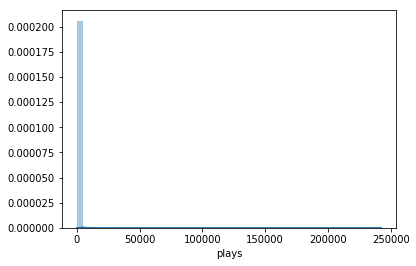

In [13]:
sns.distplot(df.plays)

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

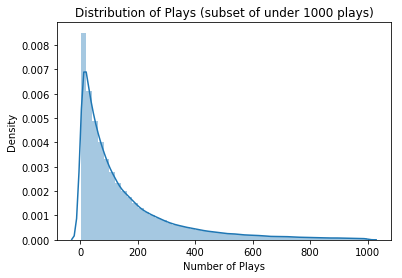

In [45]:
sns.distplot(df[df.plays < 1000].plays)
plt.title("Distribution of Plays (subset of under 1000 plays)")
plt.xlabel("Number of Plays")
plt.ylabel("Density")

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


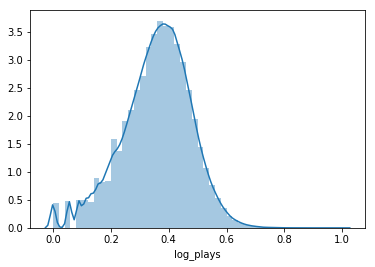

In [16]:
sns.distplot(df.log_plays)

# 1. Objective

The objective for this project is similar as before: to build a reliable recommender system that generates new and relevant artist recommendations to Last.fm users. We will do this by recommending the top-k (e.g. top 20) artists for each user. Each recommendation is personalized to each user and is ‘learnt’ from his or her listening habits and history. The business objective of our recommender system is to increase user activity in Last.fm and user loyalty to the Last.fm brand by providing a service that allows users to discover new artists and have a more enjoyable listening experience. This model is similar to Spotify's "Discover Weekly", but on an artist basis

# 2. Prepare Data

Let's first transform the dataset above to a format that is consumable by the Implicit and LightFM model.

### 2a. Create Sparse Matrix from Dataset

In [17]:
#create sparse matrix
plays_sparse = create_sparse_matrix(df).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

Creating sparse matrix...


/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.89793628874546


### 2b. Split Data to Train/Test

Split data into train test set, maintaining that each user still has some interactions intact. This custom split train test is only used for the **implicit** package. 

In [18]:
# Split data into training and test sets
train, test, user_count = split_train_test_per_user(plays_sparse, k = 3, interactions = 10)
print("Percentage of original data masked:", pct_masked(plays_sparse, train.T.tocsr()))
print("Users masked:", user_count)


Percentage of original data masked: 0.06637086337585506
Users masked: 8975


Note that the train is in the form of item by user, to accomodate the implicit and baseline models.

In [19]:
train

<47100x8999 sparse matrix of type '<class 'numpy.float64'>'
	with 432600 stored elements in Compressed Sparse Row format>

### 2c. Build Interactions for LightFM

For lightFM, we would need a different kind of format for the datasets. We create them using LightFM's data builders below.

In [37]:
import lightfm
from lightfm.data import Dataset
from lightfm import cross_validation

# Initialize lightfm Dataset()
int_df = df.drop(['artist_name', 'log_plays'], axis=1)
int_data = lightfm.data.Dataset(user_identity_features=True, item_identity_features=True)

# Create tuples for int_df values, as well as separate tuples for user_id and artist_id
tuples = [tuple(x) for x in int_df.values]
user_id = [tuple(x) for x in df.user_id]
artist_id = [tuple(x) for x in df.artist_mbid]

# Fit int_data
int_data.fit(df.user_id, df.artist_mbid)

# Build interactions, weights
interactions, weights = int_data.build_interactions(tuples)

# Create training and test sets for lightFM
train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse, test_percentage=0.6, random_state=None)

In [21]:
test_light

<8999x47100 sparse matrix of type '<class 'numpy.float64'>'
	with 259560 stored elements in COOrdinate format>

In [22]:
train_light

<8999x47100 sparse matrix of type '<class 'numpy.float64'>'
	with 173040 stored elements in COOrdinate format>

# 3. Model Fitting, Tuning, and Evaluation

Next, we set up our models to perform recommendations on the Lastfm datasets. Compared to our previous attempt, we will now use a more sophisticated take on building a recommendation engine: Factorization Machines (FM). Our motivation in using FMs is to utilize the side information we have on users (age, gender, etc.) to improve our metrics. We decided to use LightFM's implementation of FMs due to its known efficiency and good results. Our benchmarks to beat will be the "most popular" model and the ALS Implicit Matrix Factorization.

For Baseline and Implicit models, we will be focusing on the following metrics:
1. Recall at k 
2. Precision at k 
3. NDCG at k 
4. Coverage

We define recall@k as: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period.

We define precision@k as: the fraction of known positives in the first k positions of the ranked list of results.

For the LightFM models, we will be using:
1. Recall at k 
2. Precision at k
3. Coverage

NDCG isn't covered in LightFM models since it is not supported within the LightFM package. Furthermore, our attempt at calculating NDCG on our own did not turn out as expected, as the results did not make sense (much lower than recall @ k). 

## 3a. Benchmarks

### Baseline: Most Popular

The "baseline" recommends the most-popular artists to everyone, regardless of their play history. Implementation of the baseline model can be found in analysis_functions.ipynb. (To do: refactor models to separate Python scripts).

In [34]:
model_baseline = Baseline(n_recs = 20)
model_baseline.fit(train)

Fitting baseline...


No tuning is necessary since there are no parameters. We then evaluate the test set below: 

In [35]:
coverage, precision, recall, ndcg = evaluate(model_baseline, "baseline", test, plays_sparse)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

final_results = {}
final_results['model'] = ['baseline']
final_results['precision (%)'] = [precision*100]
final_results['recall (%)'] = [recall*100]
final_results['coverage (%)'] = [coverage*100]
final_results['ndcg (%)'] = [ndcg*100]


Evaluating model...



Precision: 0.9961002785515319 %
Recall: 6.64066852367688 %
Coverage: 0.042462845010615716 %
Average NDCG per User: 4.060053351196404 %


### Model-Based (ALS)

Here we fit the model-based ALS Matrix Factorization using the implicit package from our past assignment and use the parameters that were found to be optimized in the HW 2 report. 

In [36]:
model_als = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01)

# Train model
print("Fitting model...")
model_als.fit(train)

  0%|          | 0/15 [00:00<?, ?it/s]

Fitting model...


100%|██████████| 15.0/15 [00:02<00:00,  6.93it/s]


In [37]:
coverage, precision, recall, ndcg = evaluate(model_als, "implicit", test, train.T.tocsr())
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

final_results['model'].append('als')
final_results['precision (%)'].append(precision*100)
final_results['recall (%)'].append(recall*100)
final_results['coverage (%)'].append(coverage*100)
final_results['ndcg (%)'].append(ndcg*100)


Evaluating model...



Precision: 3.260724233983287 %
Recall: 21.73816155988858 %
Coverage: 8.528662420382165 %
Average NDCG per User: 0.0 %


### LightFM (without side information)

First, we fit the LightFM model without using side information, in the hopes of replicating the results of the MF models above. 

In [30]:
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, interactions, train_light, test_light)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 0.7503334898501635 %
Recall: 0.512035792205329 %
Coverage: 0.09129511677282379 %


### Troubleshooting

Shoot. It looks like our model does not replicate the results of the Implicit model. Assuming that those two results should've resulted in similar metrics, let's try a few approaches to try to improve the lightfm model.

#### Normalizing / Scaled Train-Test

First, let's use the normalized dataset to train and predict instead. 

In [31]:
df_log = df.drop(columns = ['plays'], axis = 1)
# plays_sparse = create_sparse_matrix(df).astype('float')

df_log.columns = ['user_id','artist_mbid','artist_name','plays']

#create sparse matrix
plays_sparse_log = create_sparse_matrix(df_log).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_log))

train_log, test_log = lightfm.cross_validation.random_train_test_split(plays_sparse_log, test_percentage=0.7)

model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_log, epochs=10)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, plays_sparse_log, train_log, test_log)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

Creating sparse matrix...


/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.89885948639257
Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 5.299022421240807 %
Recall: 3.129300387887679 %
Coverage: 0.7197452229299364 %


### Checking Convergence

Hmm.. that didn't fix much. Let's see if some of our metrics converge as its training and check if the training is what's the problem. Lets see if user embeddings change by epoch / recall converges by epoch. 

In [32]:
from lightfm.evaluation import recall_at_k

recall_epoch = []
user_embeddings = []
epochs = 30
for epoch in tqdm(range(epochs)):
    model_fm_vanilla.fit_partial(train_light, epochs = 1)
    recall_epoch.append(recall_at_k(model_fm_vanilla, test_light, train_light, k = 20))
    user_embeddings.append(model_fm_vanilla.get_user_representations())
    

In [39]:
recall_avg_epoch = [np.mean(x) for x in recall_epoch]

Text(0,0.5,'Recall')

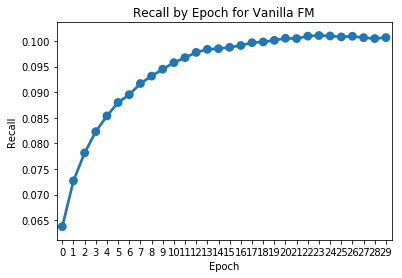

In [40]:
sns.pointplot(x = list(range(epochs)), y = recall_avg_epoch)
plt.title('Recall by Epoch for Vanilla FM')
plt.xlabel('Epoch')
plt.ylabel('Recall')

So from the results above we can see that recall eventually converges after 20 epochs. So this looks fine. 

In [48]:
user_vectors = [x[1] for x in user_embeddings]

In [57]:
user_vectors[4].shape

(8999, 10)

#### TODO: What behavior should user vectors do?

Text(0,0.5,'Recall')

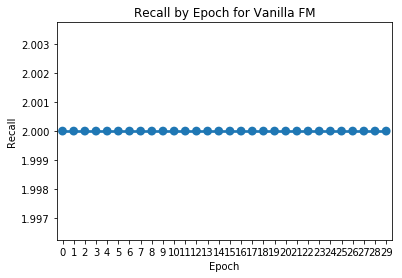

In [45]:
# sns.pointplot(x = list(range(epochs)), y = user_embedding_size)
# plt.title('Recall by Epoch for Vanilla FM')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')

### Hyperparameter

Now we try to find the best hyperparameter for this model and use the model with the best hyperparameter to get our results. Maybe tuning our parameters would get us closer to the implicit ALS. 

We first try to tune the dimensionality of the feature embeddings to try to find the best recall, which we consider it important to have at least a few items that the user consider relevant within the top k results. Recall also relates directly to precision and NDCG. At the same time, we would need to consider coverage, as we want to expand the user's tastes as much as we could. 

In [29]:
test_model = LightFM
params = [15,35,55,75,95]
param_type = "components"
k_fold = 4
n_recs = 20
ndcg_list, heatmap_list = auto_tune_parameter(k = k_fold, interactions = 20, model = test_model, data = plays_sparse, param1 = params, param_type = param_type)

Fitting fold number... 0
Trying  15
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  35
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  55
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  75
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  95
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
Fold  0  beat the record for recall!
New best recall is  0.11473180366698432
New best param is  55
end of fold---------------------------
Fitting fold number... 1
Trying  15
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  35
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  55
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  75
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  95
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
end of fold---------------------------
Fitting fold number... 2
Trying  15
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  35
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  55
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  75
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  95
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
Fold  2  beat the record for recall!
New best recall is  0.11691271483397135
New best param is  55
end of fold---------------------------
Fitting fold number... 3
Trying  15
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  35
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  55
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  75
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  95
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
Fold  3  beat the record for recall!
New best recall is  0.11696863670783234
New best param is  35
end of fold---------------------------
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
The recall on the test set is  0.12263272922378256 , after hyperparameter optimization
The precision on the test set is  0.059045926 , after hyperparameter optimization
The coverage on the test set is  0.14980891719745223 , after hyperparameter optimization


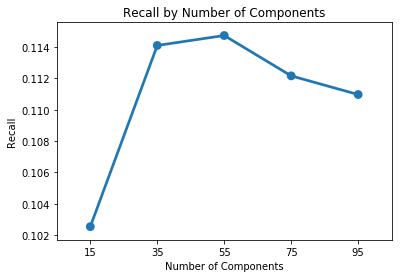

In [30]:
#Plot Recall by Number of Components
recall_values = heatmap_list[0]

recall_heatmap_components = pd.DataFrame({'N':params, 'Recall': recall_values})
sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
plt.title('Recall by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Recall')

plt.show()

Next, let's tune the best learning rate.

In [27]:
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, interactions, train_light, test_light)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

test_model = LightFM
params = [0.005, 0.01, 0.05, 0.1, 0.2]
param_type = "learning_rate"
k_fold = 4
n_recs = 20
ndcg_list, heatmap_list = auto_tune_parameter(k = k_fold, interactions = 20, model = test_model, data = plays_sparse, param1 = params, param_type = param_type)

Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 1.173299364745617 %
Recall: 0.799988302177799 %
Coverage: 0.07218683651804671 %
Fitting fold number... 0
Trying  0.005
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  0.01
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  0.05
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  0.1
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  0.2
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
Fold  0  beat the record for recall!
New best recall is  0.11455690851401841
New best param is  0.05
end of fold---------------------------
Fitting fold number... 1
Trying  0.005
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  0.01
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  0.05
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  0.1
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  0.2
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
Fold  1  beat the record for recall!
New best recall is  0.1150924453809104
New best param is  0.05
end of fold---------------------------
Fitting fold number... 2
Trying  0.005
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  0.01
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  0.05
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  0.1
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  0.2
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
end of fold---------------------------
Fitting fold number... 3
Trying  0.005
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  0.01
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  0.05
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  0.1
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  0.2
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
end of fold---------------------------
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
The recall on the test set is  0.1259337023261866 , after hyperparameter optimization
The precision on the test set is  0.060185812 , after hyperparameter optimization
The coverage on the test set is  0.20097664543524416 , after hyperparameter optimization


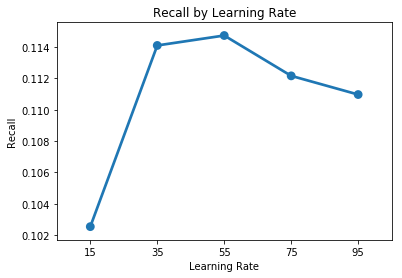

In [31]:
#Plot Recall by Number of Components
recall_values = heatmap_list[0]

recall_heatmap_components = pd.DataFrame({'N':params, 'Recall': recall_values})
sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
plt.title('Recall by Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Recall')

plt.show()

Finally, let's see which loss function is better for recall.

In [23]:
test_model = LightFM
params = ["logistic","bpr","warp"]
param_type = "loss_function"
k_fold = 4
n_recs = 20
ndcg_list, heatmap_list = auto_tune_parameter(k = k_fold, interactions = 20, model = test_model, data = plays_sparse, param1 = params, param_type = param_type)

Fitting fold number... 0
Trying  logistic
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  bpr
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  warp
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Fold  0  beat the record for recall!
New best recall is  0.11607576880833663
New best param is  warp
end of fold---------------------------
Fitting fold number... 1
Trying  logistic
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  bpr
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  warp
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
end of fold---------------------------
Fitting fold number... 2
Trying  logistic
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  bpr
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  warp
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
end of fold---------------------------
Fitting fold number... 3
Trying  logistic
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  bpr
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  warp
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
end of fold---------------------------
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
The recall on the test set is  0.12462375563680725 , after hyperparameter optimization
The precision on the test set is  0.059681732 , after hyperparameter optimization
The coverage on the test set is  0.2095116772823779 , after hyperparameter optimization


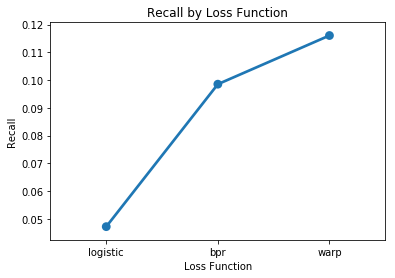

In [26]:
#Plot Recall by Number of Components
recall_values = heatmap_list[0]

recall_heatmap_components = pd.DataFrame({'N':params, 'Recall': recall_values})
sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
plt.title('Recall by Loss Function')
plt.xlabel('Loss Function')
plt.ylabel('Recall')

plt.show()

With these hyperparameters above, we would have the final result below.

In [38]:
model_fm_vanilla = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs = 25)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, interactions, train_light, test_light)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

final_results['model'].append('fm_vanilla')
final_results['precision (%)'].append(precision*100)
final_results['recall (%)'].append(recall*100)
final_results['coverage (%)'].append(coverage*100)

Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 14.168518781661987 %
Recall: 9.781221169782881 %
Coverage: 27.579617834394902 %


### LightFM (with side information)

Next, we will try to fit LightFM with side information and see if it improves our model.

In [39]:
user_feat = pd.read_csv("user_features_9000.csv")
user_feat = user_feat[user_feat.columns[1:]]
user_features = scipy.sparse.csr_matrix(user_feat.values)

In [40]:
model_fm_feat = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

# Train Model
print("Fitting model...")
model_fm_feat.fit(train_light, user_features=user_features, epochs = 25)

coverage, precision, recall = evaluate_lightfm(model_fm_feat, plays_sparse, train_light, test_light, user_features=user_features)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

final_results['model'].append('fm_with_features')
final_results['precision (%)'].append(precision*100)
final_results['recall (%)'].append(recall*100)
final_results['coverage (%)'].append(coverage*100)

Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 4.71709705889225 %
Recall: 3.2538472963803597 %
Coverage: 13.1104033970276 %


### Troubleshooting

Shoot. Adding user features doesn't help either. Let's take a look at our user_features and see if there's a problem with it inherently.

In [4]:
col_names = ['user_id','sex','age','country','dob']
data_raw = pd.read_csv("user_side_data_raw.tsv", sep = "\t", header = None, names = col_names)
data_raw.head()

user_id  sex   age        country  \
0  00000c289a1829a808ac09c00daf10bc3c4e223b    f  22.0        Germany   
1  00001411dc427966b17297bf4d69e7e193135d89    f   NaN         Canada   
2  00004d2ac9316e22dc007ab2243d6fcb239e707d  NaN   NaN        Germany   
3  000063d3fe1cf2ba248b9e3c3f0334845a27a6bf    m  19.0         Mexico   
4  00007a47085b9aab8af55f52ec8846ac479ac4fe    m  28.0  United States   

            dob  
0   Feb 1, 2007  
1   Dec 4, 2007  
2   Sep 1, 2006  
3  Apr 28, 2008  
4  Jan 27, 2006

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359347 entries, 0 to 359346
Data columns (total 5 columns):
user_id    359347 non-null object
sex        326572 non-null object
age        284447 non-null float64
country    359347 non-null object
dob        359347 non-null object
dtypes: float64(1), object(4)
memory usage: 13.7+ MB


In [6]:
data_raw.isna().sum()

user_id        0
sex        32775
age        74900
country        0
dob            0
dtype: int64

~9% of sex is null

In [9]:
data_raw.isna().sum().sex/float(data_raw.user_id.unique().shape[0])

0.09120710622323269

~21% of age is null/below 10

In [10]:
(data_raw.isna().sum().age + data_raw[data_raw.age < 10].shape[0])/float(data_raw.user_id.unique().shape[0])


0.21171736510949027

In [11]:
data_raw.describe()

age
count  284447.000000
mean       25.098046
std        21.665742
min     -1337.000000
25%        20.000000
50%        23.000000
75%        28.000000
max      1002.000000

As we can see above, the user_data is not perfect and we have a significant null value for ages and also gender. Even if we combine these null values as "other" category, it does not improve the model. Let's see later if having more data would increase accuracy.

TO DO: if have enough time, find best hyperparameter for this FM model too.

### Summary of Performance Results (Table)

We summarize the results below for both Implicit and LightFM models:

In [47]:
final_results.pop('ndcg (%)', None)

[4.060053351196404, 0.0]

In [48]:
pd.DataFrame.from_dict(final_results)

model  precision (%)  recall (%)  coverage (%)
0          baseline       0.996100    6.640669      0.042463
1               als       3.260724   21.738162      8.528662
2        fm_vanilla      14.168519    9.781221     27.579618
3  fm_with_features       4.717097    3.253847     13.110403

# 4. Model Exploration

Next, we explore these models even more. How do they perform in regards to size, different user population? In our exploration we will focus on three user segments:
1. **Activity**: users that have a large number of plays vs those that do not.

2. **Diversity**: users that listen to a large number of artists equally vs those that listen only to a specific set of artists. We measure diversity by attaching a diversity score to each user, which is calculated by the spread of listens across all artists played. The artist plays for each user is scaled to between 0 and 1, where 1 is attached to the artist with the most number of plays for that user. The score is then computed by taking the sum of these scaled values. This means that users who have listened to more artists generally have a higher diversity score. Furthermore, it also means that users whose artist plays are more evenly spread out have a higher diversity score as well. For example, a user with [500, 1, 1, 1] listens will have a lower score than a user with [200, 50, 150, 125] listens.

3. **Mainstreamness**: users that listen only to popular artists at the time vs. none who do. We measure how ‘mainstream’ each user is by similarly attaching to them a score, which is determined by their weighted plays of popular artists. We first compute the popularity of each artist by calculating their respective total plays across all users. Following which, we assign an indicator for how mainstream a user is by computing the weighted total of listens to the top n artists. n is a parameter that we can tune to adjust which artists are considered ‘popular’.


## 4a. Performance by User Type

We split the users along three different scales as described above. 

In [ ]:
#import functions to group users by different segments.

In [86]:
run grouping_functions.ipynb

### Active/Non-Active

In [87]:
import seaborn as sns

In [88]:
n=3
activity_groups=active_users(plays_sparse, n)
levels=[1,2,3]
#initialize lists
recall_activity_als = []
precision_activity_als = []
coverage_activity_als = []

recall_activity_baseline = []
precision_activity_baseline = []
coverage_activity_baseline = []

recall_activity_fm = []
precision_activity_fm = []
coverage_activity_fm = []

for group in activity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    recall_activity_baseline.append(recall)
    precision_activity_baseline.append(precision)
    coverage_activity_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_activity_als.append(recall)
    precision_activity_als.append(precision)
    coverage_activity_als.append(coverage)
    
    #THIRD, LIGHTFM----------------------------------
    train_light_plot, test_light_plot = lightfm.cross_validation.random_train_test_split(group, test_percentage=0.75, random_state=None)
    model = LightFM(no_components=50, loss='warp')
    model.fit(train_light_plot, user_features=user_features,epochs=25)
    coverage, precision, recall = evaluate_lightfm(model, group, train_light_plot, test_light_plot, user_features=user_features)

    recall_activity_fm.append(recall)
    precision_activity_fm.append(precision)
    coverage_activity_fm.append(coverage)

Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.83it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  7.94it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:01<00:00,  7.85it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


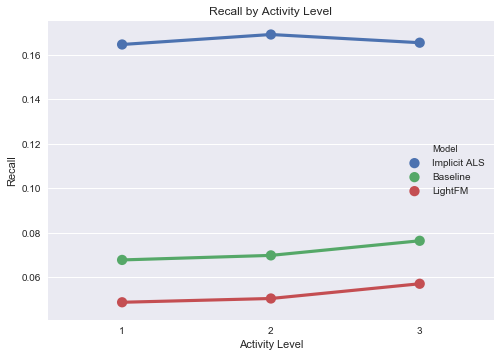

In [89]:
# Plot Recall by Activity Level
recall_activity_als_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_als})
recall_activity_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_baseline})
recall_activity_fm_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_fm})

f, ax = plt.subplots(1, 1)

recall_activity_als_df['Model'] = 'Implicit ALS'
recall_activity_baseline_df['Model'] = 'Baseline'
recall_activity_fm_df['Model'] = 'LightFM'

df = pd.concat([recall_activity_als_df,recall_activity_baseline_df,recall_activity_fm_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Recall')

plt.show()

Above is a graph of Recall by Activity Level. Note that Implicit ALS does very well compared to LightFM (which does very poorly). Next we plot Precision by Activity Level: Note that the Precision of LightFM is fairly high.

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


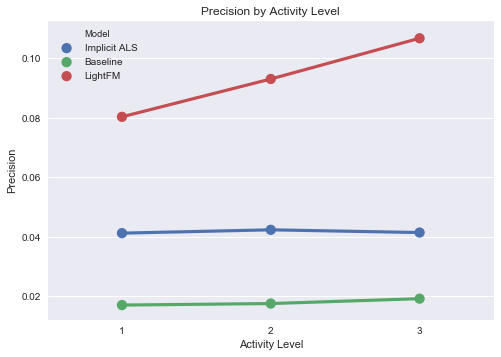

In [90]:
# Plot Precision by Activity Level
precision_activity_als_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_als})
precision_activity_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_baseline})
precision_activity_fm_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_fm})
f, ax = plt.subplots(1, 1)

precision_activity_als_df['Model'] = 'Implicit ALS'
precision_activity_fm_df['Model'] = 'LightFM'
precision_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_activity_als_df,precision_activity_baseline_df,precision_activity_fm_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Precision')

plt.show()

Below we plot the Coverage by Activity level. Implicit ALS does very well whereas baseline and LightFM has a very narrow range of recommendations.

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


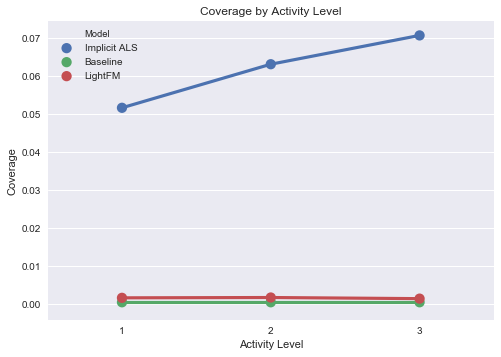

In [91]:
# Plot Coverage by Activity Level
coverage_activity_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_als})
coverage_activity_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_baseline})
coverage_activity_fm_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_fm})

f, ax = plt.subplots(1, 1)

coverage_activity_als_df['Model'] = 'Implicit ALS'
coverage_activity_baseline_df['Model'] = 'Baseline'
coverage_activity_fm_df['Model'] = 'LightFM'
df = pd.concat([coverage_activity_als_df,coverage_activity_baseline_df,coverage_activity_fm_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Coverage')

plt.show()

### Diverse/Non-Diverse

Next we looked at the split between groups of varying levels of diversity in music taste. 

In [94]:
n=3
diversity_groups=diverse_users(plays_sparse, n)
levels=[1,2,3]
recall_div_als = []
precision_div_als = []
coverage_div_als = []

recall_div_baseline = []
precision_div_baseline = []
coverage_div_baseline = []

recall_div_fm = []
precision_div_fm = []
coverage_div_fm = []

for group in diversity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    precision_div_baseline.append(precision)
    coverage_div_baseline.append(coverage)
    recall_div_baseline.append(recall)

    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_div_als.append(recall)
    precision_div_als.append(precision)
    coverage_div_als.append(coverage)
    
    #THIRD, LIGHTFM-----------------------------------
    train_light_plot, test_light_plot = lightfm.cross_validation.random_train_test_split(group, test_percentage=0.75, random_state=None)
    model = LightFM(no_components=50, loss='warp')
    model.fit(train_light_plot, user_features=user_features,epochs=25)
    coverage, precision, recall = evaluate_lightfm(model, group, train_light_plot, test_light_plot, user_features=user_features)

    recall_div_fm.append(recall)
    precision_div_fm.append(precision)
    coverage_div_fm.append(coverage)

Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:01<00:00,  8.48it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.86it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.52it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


The next three plots are plots of Recall, Precision, and Coverage by Diversity Level. Note that the Diversity level does not seem to strongly affect the scores of any of these models. Again, Implicit ALS does very well in recall. 

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


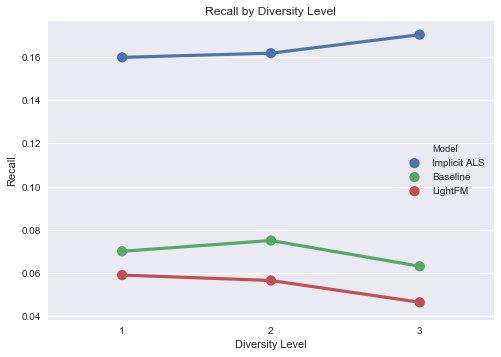

In [95]:
# Plot Recall by Diversity Level
recall_div_als_df = pd.DataFrame({'N':levels, 'Recall': recall_div_als})
recall_div_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_div_baseline})
recall_div_fm_df = pd.DataFrame({'N':levels, 'Recall': recall_div_fm})

f, ax = plt.subplots(1, 1)

recall_div_als_df['Model'] = 'Implicit ALS'
recall_div_baseline_df['Model'] = 'Baseline'
recall_div_fm_df['Model'] = 'LightFM'
df = pd.concat([recall_div_als_df,recall_div_baseline_df,recall_div_fm_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


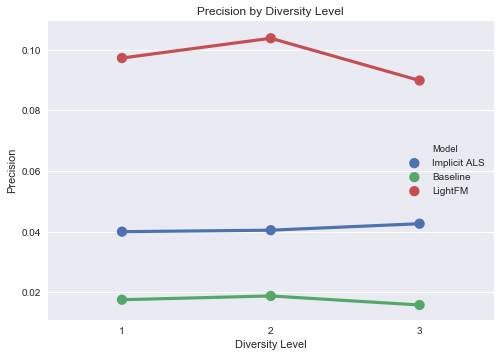

In [96]:
# Plot Precision by Diversity Level
precision_div_als_df = pd.DataFrame({'N':levels, 'Precision': precision_div_als})
precision_div_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_div_baseline})
precision_div_fm_df = pd.DataFrame({'N':levels, 'Precision': precision_div_fm})

f, ax = plt.subplots(1, 1)

precision_div_als_df['Model'] = 'Implicit ALS'
precision_div_baseline_df['Model'] = 'Baseline'
precision_div_fm_df['Model'] = 'LightFM'

df = pd.concat([precision_div_als_df,precision_div_baseline_df,precision_div_fm_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


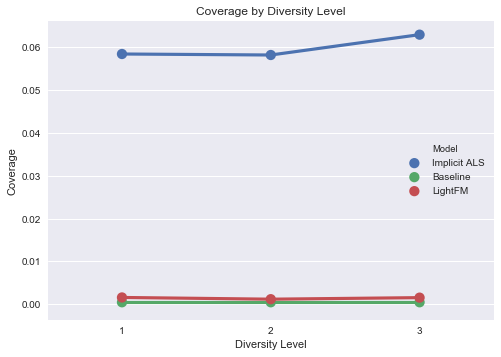

In [97]:
# Plot Coverage by Diversity Level
coverage_div_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_als})
coverage_div_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_baseline})
coverage_div_fm_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_fm})

f, ax = plt.subplots(1, 1)

coverage_div_als_df['Model'] = 'Implicit ALS'
coverage_div_baseline_df['Model'] = 'Baseline'
coverage_div_fm_df['Model'] = 'LightFM'

df = pd.concat([coverage_div_als_df,coverage_div_baseline_df,coverage_div_fm_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Coverage')

plt.show()

### Mainstream / Non-Mainstream

Finally, we break up the users by groups of varying levels of mainstreamness in their music listening habits. 

In [98]:
n=3
ms_groups=mainstream_users(plays_sparse, top_artists=20, n=3)
levels=[1,2,3]
recall_ms_als = []
precision_ms_als = []
coverage_ms_als = []

recall_ms_baseline = []
precision_ms_baseline = []
coverage_ms_baseline = []

recall_ms_fm = []
precision_ms_fm = []
coverage_ms_fm = []

for group in ms_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    recall_ms_baseline.append(recall)
    precision_ms_baseline.append(precision)
    coverage_ms_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_ms_als.append(recall)
    precision_ms_als.append(precision)
    coverage_ms_als.append(coverage)
    
    #THIRD, LIGHTFM-----------------------------------
    train_light_plot, test_light_plot = lightfm.cross_validation.random_train_test_split(group, test_percentage=0.75, random_state=None)
    model = LightFM(no_components=50, loss='warp')
    model.fit(train_light_plot, user_features=user_features,epochs=25)
    coverage, precision, recall = evaluate_lightfm(model, group, train_light_plot, test_light_plot, user_features=user_features)

    recall_ms_fm.append(recall)
    precision_ms_fm.append(precision)
    coverage_ms_fm.append(coverage)

Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.12it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  7.83it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:01<00:00,  9.44it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Here we see interesting trends: The more mainstream a user is, the better the quality of the recommendation. This is seen in all three models. It also makes sense that the more mainstream a user is, the more precise the recommendation is (since it's narrowed to the most popular music) and the less the coverage is (also because of this narrowness). Thus, these graphs make intuitive sense.

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


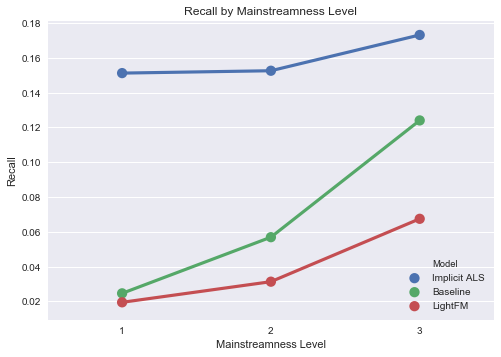

In [99]:
# Plot Recall by Mainstreamness Level
recall_ms_als_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_als})
recall_ms_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_baseline})
recall_ms_fm_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_fm})

f, ax = plt.subplots(1, 1)

recall_ms_als_df['Model'] = 'Implicit ALS'
recall_ms_baseline_df['Model'] = 'Baseline'
recall_ms_fm_df['Model'] = 'LightFM'

df = pd.concat([recall_ms_als_df,recall_ms_baseline_df,recall_ms_fm_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


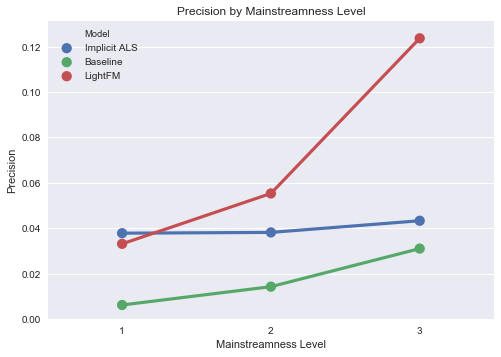

In [100]:
# Plot Precision by Mainstreamness Level
precision_ms_als_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_als})
precision_ms_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_baseline})
precision_ms_fm_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_fm})

f, ax = plt.subplots(1, 1)

precision_ms_als_df['Model'] = 'Implicit ALS'
precision_ms_baseline_df['Model'] = 'Baseline'
precision_ms_fm_df['Model'] = 'LightFM'

df = pd.concat([precision_ms_als_df,precision_ms_baseline_df,precision_ms_fm_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


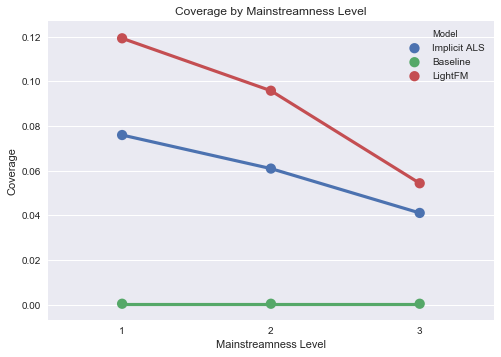

In [101]:
# Plot Coverage by Mainstreamness Level
coverage_ms_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_als})
coverage_ms_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_baseline})
coverage_ms_fm_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_fm})

f, ax = plt.subplots(1, 1)

coverage_ms_als_df['Model'] = 'Implicit ALS'
coverage_ms_baseline_df['Model'] = 'Baseline'
coverage_ms_fm_df['Model'] = 'LightFM'

df = pd.concat([coverage_ms_als_df,coverage_ms_baseline_df,coverage_ms_fm_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Coverage')

plt.show()

## 4b. Performance by Input Size 

Next, we will see how our model scales, in regards to accuracy and running time. 

In [ ]:
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
import time

colnames = ['user_id','artist_mbid','artist_name','plays']

#to perform this analysis, download full dataset at https://www.dropbox.com/s/wlhkyz8yn51cpnk/360k_users.zip?dl=0
#user features can be downloaded at https://www.dropbox.com/s/2lxoe3qojzsxr2z/user_features.zip?dl=0

df_all = pd.read_csv("usersha1-artmbid-artname-plays.tsv", sep = "\t", names = colnames)
df_all = df_all[df_all.artist_mbid != '']
df_all = df_all[df_all.artist_name != '']
df_all = df_all.dropna()

sizes = ["user_features_9000.csv","user_features_20k.csv","user_features_60k.csv","user_features_150k.csv"]

precision_all = []
recal_all = []
coverage_all = []
train_time = []
recommend_time = []

for size in sizes: 
    
    print("Working on ", size, "...")
    
    #get user features
    user_feat = pd.read_csv("user_features/" + size)
    
    if size != "user_features_9000.csv":
        user_feat = user_feat.drop(columns = "Unnamed: 0", axis = 1)

    #only grab the data that has the user features above
    df_subset = df_all[df_all.user_id.isin(set(user_feat.id.unique()))].reset_index()
    df_subset = df_subset[df_subset.artist_mbid != '']
    df_subset = df_subset[df_subset.artist_name != '']
    df_subset = df_subset.dropna()
    
    
    #trim user features incase some are missing
    user_feat = user_feat[user_feat.id.isin(set(df_subset.user_id.unique()))].reset_index()
    
    #create user feature sparse matrix
    user_features = user_feat[user_feat.columns[2:]]
    user_features = scipy.sparse.csr_matrix(user_features.values)
    assert df_subset.user_id.unique().shape[0] == user_feat.id.unique().shape[0]
    
    #create FM model with tuned parameters
    model_fm = LightFM(learning_rate=0.05, loss='warp', no_components = 50)
    
    #create sparse matrix for data
    plays_sparse = create_sparse_matrix(df_subset).astype('float')
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))
    
    print("Splitting train/test...")
    #split train test
    train,test = random_train_test_split(plays_sparse)
    
    #calculate time to train
    start = time.time()
    
    print("Fitting model...")
    #train model
    model_fm.fit(train, epochs = 25, user_features = user_features)
    
    end = time.time()
    train_t = end-start
    

    print("Evaluating model...")
    #evaluate model 
    coverage, precision, recall = evaluate_lightfm(model_fm, plays_sparse, train, test, user_features = user_features)
    print("Precision:",precision*100,'%')
    print("Recall:",recall*100,'%')
    print("Coverage:",coverage*100,'%')

    #calculate time to recommend
    start = time.time()
    
    (-model_fm.predict(0,np.arange(plays_sparse.shape[1]))).argsort()[:20]
    
    end = timeit.timeit()
    
    recommend_t = end-start
    
    precision_all.append(precision)
    recal_all.append(recall)
    coverage_all.append(coverage)
    train_time.append(train_t)
    recommend_time.append(recommend_t)

In [ ]:
size = [9000, 20000, 60000, 150000]

sns.pointplot(x = size, y = precision_all)
plt.title("Precision by Input Size")
plt.xlabel("Number of Users")
plt.ylabel("Precision")

In [ ]:
sns.pointplot(x = size, y = recal_all)
plt.title("Recall by Input Size")
plt.xlabel("Number of Users")
plt.ylabel("Recall")

In [ ]:
sns.pointplot(x = size, y = coverage_all)
plt.title("Coverage by Input Size")
plt.xlabel("Number of Users")
plt.ylabel("Coverage")

In [ ]:
sns.pointplot(x = size, y = train_time)
plt.title("Train Time by Input Size")
plt.xlabel("Number of Users")
plt.ylabel("Train Time (seconds)")

In [ ]:
sns.pointplot(x = size, y = recommend_time)
plt.title("Recommend Time by Input Size")
plt.xlabel("Number of Users")
plt.ylabel("Recommend Time (seconds)")

## 4c. Qualitative Results

On top of accuracy metrics, let's see how the recommender system works qualitatively. Since its difficult to quantify serendipity, we also can use this qualitative method to determine serendipity of our model. Below are some "new users" that we create to qualitatively see how our models do. Since we don't have any idea how our data values relates to time, we are won't be able to determine novelty.

In [14]:
#Helper functions to definition
def add_user(data, new_user, value = 1000):
    """
    Add new users to dataframe. 
    
    Input: 
    - data (pd.DataFrame): dataframe to add to 
    - new_user (tuple): tuple containing user name and list of artists they listen to ('tim', ['mouserat',...])
    
    Returns: 
    - Dataframe containing new user data.
    
    """
    col_names = ['user_id','artist_mbid','artist_name','plays']
    mbid_dict = pd.Series(data.artist_mbid.values, index = data.artist_name).to_dict()
    final = []
    
    user_name = new_user[0]
    user_artists = new_user[1]
    
    for artist in user_artists:
        final.append([user_name, mbid_dict[artist], artist, value])
    return pd.concat([data, pd.DataFrame(final, columns = col_names)])

def create_artist_mapping(data):
    """
    Create a mapping from index (0,1,2) to corresponding artist name (mouserat, etc)
    
    Input:
    - data (pd.DataFrame): dataframe containing artists mbid/name to create a mapping of
    
    Returns:
    - artist_map (dict): dictionary containing indexes mapped to artist names
    """
    artists = list(data.artist_mbid.unique())
    artist_categories = data.artist_mbid.astype('category', categories=artists).cat.categories
    name_dict = pd.Series(data.artist_name.values, index = data.artist_mbid).to_dict()
    artist_map = dict((i, name_dict[x]) for (i, x) in enumerate(artist_categories))
    return artist_map

def create_user_mapping(data):
    """
    Create a mapping from user_id ('33r3nsss') to index (0,1,2)
    
    Input:
    - data (pd.DataFrame): dataframe containing user id to create a mapping of
    
    Returns:
    - user_map (dict): dictionary containing user ids mapped to indexes
    """
    users = list(data.user_id.unique())
    user_categories = data.user_id.astype('category', categories=users).cat.categories
    user_map = dict((x, i) for (i, x) in enumerate(user_categories))
    return user_map

def get_artist_name(list_idx, artist_mapping):
    """
    Get artist name from a given artist mapping.
    
    Input:
    - list_idx (list of ints): integers to get artist names from
    - artist_mapping (dict): dictionary to get artist names from
    """
    return [artist_mapping[idx] for idx in list_idx]

### What is mainstream/popular in this dataset?

First, let's determine qualitatively what artists are most popular at this time in lastFM. It's interesting to note how the most popular artists are mainly rock/alternative rock for this dataset.

In [7]:
artist_mapping = create_artist_mapping(df)
get_artist_name(model_baseline.predict(), artist_mapping)

NameError: name 'df' is not defined

### New Users

Next, let's create "new users" to see how our model predicts artists for them. Below are some users that are in the different segments above, as well as our own team members to test a sense of serendipity.

In [12]:
#create user profiles to determine serendipity
artists_rock = [
    'the beatles',
    'the rolling stones',
    'led zeppelin',
    'queen',
    'pink floyd',
    'ac/dc',
    'guns n\' roses',
    'aerosmith'
]

artists_rap = [
    'kanye west',
    '2pac',
    'lil wayne',
    'eminem',
    'young jeezy',
    'jay-z',
    'drake'
]

artists_tim = [
    'daft punk',
    'deadmau5',
    'john mayer',
    'hans zimmer',
    'coldplay'
]

artists_char = [
           'solange', 
           'sufjan stevens',  
           'beirut', 
           'yo la tengo', 
           'little dragon', 
           'crystal castles', 
           'a tribe called quest', 
           'radiohead', 
           'faye wong',
           'the beach boys',
           'van morrison',
           'marvin gaye',
           'whitney houston',
           'kanye west',
           'curtis mayfield',
           '2pac',
           'eagles',
           'david bowie',
           'prince'
]

artists_fernando = [
    'u2', 'the killers', 'coldplay', 'john mayer', 'eminem', 'justin timberlake', 'kanye west', 'linkin park', 'weezer', 'radiohead', 'frank sinatra'
]
new_users = [('rap', artists_rap),('rock', artists_rock), ('tim', artists_tim), ('char', artists_char), ('fernando', artists_fernando)]

### Implicit

First, let's see how our Implicit ALS model performs in predicting these new users. 

In [13]:
#use implicit to get recommended for users
model_als = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01)

for new in new_users: 
    new_users_df = add_user(df, new, 1000)

    #create mappings
    artist_mapping = create_artist_mapping(new_users_df)
    user_mapping = create_user_mapping(new_users_df)

    plays_sparse = create_sparse_matrix(new_users_df)
    train, test, user_count = split_train_test_per_user(plays_sparse, 3, 10)

    # Train model
    print("Fitting model...")
    model_als.fit(train)

    recs = model_als.recommend(user_mapping[new[0]], train.T.tocsr(), N=20, filter_already_liked_items=True)#, artist_mapping) #returns (item_id, score)
    recs = [x[0] for x in recs]
    
    print("User ", new[0], " :\n", get_artist_name(recs, artist_mapping))

    

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  app.launch_new_instance()
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Creating sparse matrix...


/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


  7%|▋         | 1.0/15 [00:00<00:01,  9.97it/s]


Fitting model...


100%|██████████| 15.0/15 [00:01<00:00,  9.27it/s]


User  rap  :
 ['the game', 'lupe fiasco', 't.i.', 'nas', 'ludacris', 'justin timberlake', 'akon', '50 cent', 'chamillionaire', 'notorious b.i.g.', 'n*e*r*d', 't-pain', 'timbaland', 'outkast', 'ice cube', 'fabolous', 'nelly', 'kid cudi', 'bone thugs-n-harmony', 'gym class heroes']
Creating sparse matrix...


  7%|▋         | 1.0/15 [00:00<00:01,  9.78it/s]


Fitting model...


100%|██████████| 15.0/15 [00:01<00:00,  9.10it/s]


User  rock  :
 ['martingo', 'u2', 'red hot chili peppers', 'nirvana', 'metallica', 'coldplay', 'green day', 'radiohead', 'muse', 'r.e.m.', 'the doors', 'the who', 'bob marley', 'oasis', 'foo fighters', 'bob dylan', 'linkin park', 'system of a down', 'nightwish', 'the killers']
Creating sparse matrix...


  7%|▋         | 1.0/15 [00:00<00:01,  9.21it/s]


Fitting model...


100%|██████████| 15.0/15 [00:01<00:00,  8.65it/s]


User  tim  :
 ['martingo', 'michael jackson', 'soundtrack', 'justin timberlake', 'red hot chili peppers', 'timbaland', 'the beatles', 'linkin park', 'the prodigy', 'the killers', 'david guetta', 'radiohead', 'muse', 'bob marley', 'dj tiësto', 'john legend', 'kanye west', 'moby', 'u2', 'maroon 5']
Creating sparse matrix...


  0%|          | 0/15 [00:00<?, ?it/s]


Fitting model...


100%|██████████| 15.0/15 [00:01<00:00,  7.48it/s]


User  char  :
 ['clueso', 'the beatles', 'beatsteaks', 'deichkind', 'peter fox', 'böhse onkelz', 'coldplay', 'blumentopf', 'die fantastischen vier', 'tocotronic', 'k.i.z.', 'mando diao', 'jan delay', 'radiohead', 'absolute beginner', 'metallica', 'the killers', 'pink floyd', 'freundeskreis', 'in extremo']
Creating sparse matrix...


  7%|▋         | 1.0/15 [00:00<00:01,  9.52it/s]


Fitting model...


100%|██████████| 15.0/15 [00:02<00:00,  7.35it/s]

User  fernando  :
 ['clueso', 'deichkind', 'the beatles', 'peter fox', 'beatsteaks', 'coldplay', 'die fantastischen vier', 'blumentopf', 'tocotronic', 'k.i.z.', 'mando diao', 'absolute beginner', 'jan delay', 'böhse onkelz', 'radiohead', 'metallica', 'the killers', 'pink floyd', 'the white stripes', 'rammstein']


### LightFM

First, let's see how lightFM without user features perform.

In [14]:
#use implicit to get recommended for users
from lightfm.cross_validation import random_train_test_split

#create FM model with tuned parameters
model_fm = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

for new in new_users: 
    new_users_df = add_user(df, new, 1000)

    #create mappings
    artist_mapping = create_artist_mapping(new_users_df)
    user_mapping = create_user_mapping(new_users_df)
    
    #create sparse matrix
    plays_sparse = create_sparse_matrix(new_users_df)
    
    #split train test
    train,test = random_train_test_split(plays_sparse)

    print("training...")
    #train model
    model_fm.fit(train, epochs = 25)
    
    print("recommending...")
    #get recommendation from model
    recs = (-model_fm.predict(0,np.arange(plays_sparse.shape[1]))).argsort()[:20]
    
    print("User ", new[0], " :\n", get_artist_name(recs, artist_mapping))

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  app.launch_new_instance()
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Creating sparse matrix...
training...
recommending...
User  rap  :
 ['joy division', 'david bowie', 'the cure', 'nick cave and the bad seeds', 'pj harvey', 'portishead', 'martingo', 'the velvet underground', 'pixies', 'pink floyd', 'nine inch nails', 'the smiths', 'johnny cash', 'tom waits', 'siouxsie and the banshees', 'radiohead', 'björk', 'the beatles', 'neil young', 'rammstein']
Creating sparse matrix...
training...
recommending...
User  rock  :
 ['joy division', 'the cure', 'martingo', 'tom waits', 'depeche mode', 'siouxsie and the banshees', 'pj harvey', 'radiohead', 'david bowie', 'pixies', 'the smiths', 'nine inch nails', 'portishead', 'pink floyd', 'nick cave and the bad seeds', 'sonic youth', 'the sisters of mercy', 'bauhaus', 'morrissey', 'the clash']
Creating sparse matrix...
training...
recommending...
User  tim  :
 ['the cure', 'depeche mode', 'radiohead', 'pink floyd', 'joy division', 'david bowie', 'martingo', 'the beatles', 'the doors', 'pixies', 'nirvana', 'the white 

Next, let's see how lightFM with user features performs. 

In [ ]:
#use implicit to get recommended for users
from lightfm.cross_validation import random_train_test_split

user_feat = pd.read_csv("user_features_9000.csv")
user_feat = user_feat[user_feat.columns[1:]]
user_features = scipy.sparse.csr_matrix(user_feat.values)

#create FM model with tuned parameters
model_fm = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

for new in new_users: 
    new_users_df = add_user(df, new, 1000)

    #create mappings
    artist_mapping = create_artist_mapping(new_users_df)
    user_mapping = create_user_mapping(new_users_df)
    
    #create sparse matrix
    plays_sparse = create_sparse_matrix(new_users_df)
    
    #split train test
    train,test = random_train_test_split(plays_sparse)

    print("training...")
    #train model
    model_fm.fit(train, epochs = 25, user_features = user_features)
    
    print("recommending...")
    #get recommendation from model
    recs = (-model_fm.predict(0,np.arange(plays_sparse.shape[1]),user_features = user_features)).argsort()[:20]
    
    print("User ", new[0], " :\n", get_artist_name(recs, artist_mapping))

# 5. Conclusion / Next Steps

In conclusion, we found that Implicit’s ALS Matrix Factorization is still the best model to provide top-k recommendations for the LastFM dataset. The LightFM model did not perform as well as we anticipated, failing to reach the recall rate of the Implicit model even without side information. We hypothesize that this is because the Implicit package is tuned and better suited for non-binary implicit data like LastFM. Furthermore, adding side information decreased the accuracy of the model, which we hypothesized to be due to the quality of the side information. Even though the LightFM model is scalable in regards to accuracy and training time, ALS still outperforms LightFM in scale. When users were split along scales of activity level, diversity of musical tastes, and “mainstreamness”, “mainstreamness” proved to be the best indicator of recommendation quality. The more mainstream a user’s listening activity is, the better our models were able to recommend music to them. And as was true in previous tests, ALS outperformed the other models in terms of recall while LightFM had fairly high precision. Qualitatively, ALS also is shown to provide recommendations that are better suited to a user’s taste, not defaulting to popular music like LightFM.
Moving forward, we can further attempt to improve the model’s accuracy metrics by gaining cleaner data in regards to user demographics and item metadata. Outside of Factorization Machines, we can try other methodologies to improve recommendations, such as association rules and MNAR.
